<a href="https://colab.research.google.com/github/Shawny1998/Twitter-Sentimental/blob/main/TwitterDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install pyspark py4j
from pyspark.sql import SparkSession

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, regexp_replace, when
from pyspark.sql.functions import *
from pyspark.sql.types import StringType,IntegerType,FloatType,DoubleType, ArrayType
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import re
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pickle import FALSE

Building a spark session

In [11]:
spark = SparkSession.builder \
    .appName("Twitter Sentiment Analysis") \
    .getOrCreate()

Loading in the data and creating titles for each column

In [12]:
path = "/content/training.1600000.processed.noemoticon.csv"
column_names = ['target', 'id', 'date', 'flag', 'username', 'tweet']
data = spark.read.csv(path, inferSchema=True, header=False, encoding="ISO-8859-1")
data = data.toDF(*column_names)
data = data.withColumn("target", col("target").cast("double"))

Preprocessing the data by removing anything not containing a-z uppercase or lower case

*   split the sentence into words
*   removes stopwords
*   words to lowercase
*   words to base(running to run)





In [13]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
def preprocess_text(content):
    content = re.sub('[^a-zA-Z]', ' ', content).lower().split()
    stemmed_words = [word for word in content if word not in stop_words]
    return ' '.join(stemmed_words)

preprocess_udf = udf(preprocess_text, StringType())

Changing target value of 4 to 1
Applying preprocess to dataset

In [14]:
data = data.withColumn("target", when(col("target") == 4, 1).otherwise(col("target")))
data = data.withColumn("clean_tweet", preprocess_udf(col("tweet")))
data.show(10)

+------+----------+--------------------+--------+---------------+--------------------+--------------------+
|target|        id|                date|    flag|       username|               tweet|         clean_tweet|
+------+----------+--------------------+--------+---------------+--------------------+--------------------+
|   0.0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|switchfoot http t...|
|   0.0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|upset update face...|
|   0.0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|kenichan dived ma...|
|   0.0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|whole body feels ...|
|   0.0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|nationwideclass b...|
|   0.0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...| kwesidei whole crew|
|   0.0|1467811592|Mon Apr 0

Graphing the Target counts

Negative count: 800000
Positive count: 800000


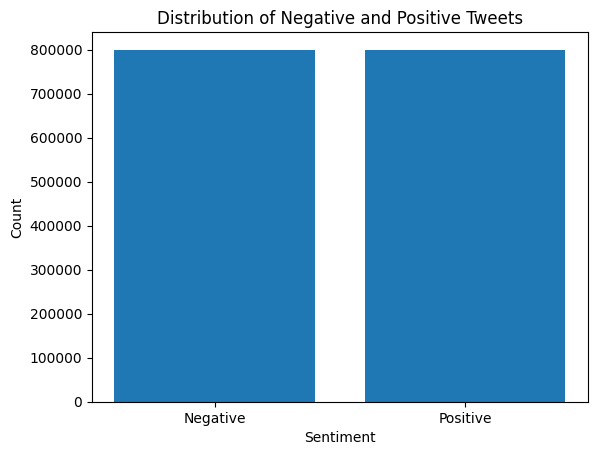

In [15]:
negative_count = data.filter(col("target") == 0).count()
positive_count = data.filter(col("target") == 1).count()
print("Negative count:", negative_count)
print("Positive count:", positive_count)

# Plot distribution of negative and positive tweets
plt.bar(["Negative", "Positive"], [negative_count, positive_count])
plt.title("Distribution of Negative and Positive Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Calculating Postive and Negative Tweets

In [17]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType

# Read positive and negative words into DataFrames
positive_words = spark.read.text("/content/positive-words.txt")
negative_words = spark.read.text("/content/negative-words.txt")

positive_words_list = positive_words.rdd.map(lambda row: row[0]).collect()
negative_words_list = negative_words.rdd.map(lambda row: row[0]).collect()

def calculate_sentiment(clean_tweet):
    words = clean_tweet.split()
    # Changed these two lines to fix the error
    positive_count = len([word for word in words if word in positive_words_list])
    negative_count = len([word for word in words if word in negative_words_list])
    total_count = len(words)
    if total_count == 0:
        return 0.5 #neutral sentiment
    positive_prob = positive_count / total_count
    negative_prob = negative_count / total_count
    if positive_prob > negative_prob:
        return 1.0
    else:
        return 0.0

sentiment_udf = udf(calculate_sentiment, DoubleType())

data = data.withColumn("sentiment", sentiment_udf(col("clean_tweet")))
data.show()

+------+----------+--------------------+--------+---------------+--------------------+--------------------+---------+
|target|        id|                date|    flag|       username|               tweet|         clean_tweet|sentiment|
+------+----------+--------------------+--------+---------------+--------------------+--------------------+---------+
|   0.0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|switchfoot http t...|      0.0|
|   0.0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|upset update face...|      0.0|
|   0.0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|kenichan dived ma...|      0.0|
|   0.0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|whole body feels ...|      0.0|
|   0.0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|nationwideclass b...|      0.0|
|   0.0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       

Applying Logistic Regression Model

In [18]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

Applying Logistic Regression Model

In [ ]:
vecAssembler = VectorAssembler(inputCols=['sentiment'], outputCol="features")
data = vecAssembler.transform(data)
train, test = data.randomSplit([0.7, 0.3], seed=2030)

logistic_regression = LogisticRegression(labelCol="target", featuresCol="features")
model_lr = logistic_regression.fit(train)

predictions_lr = model_lr.transform(test)

evaluator_lr = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction")
accuracy_lr = evaluator_lr.evaluate(predictions_lr)
print("Logistic Regression Test Area Under ROC:", accuracy_lr)

Applying the Naive Bayes Model

In [ ]:
# Train Naive Bayes model
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="target")
model_nb = nb.fit(train)
predictions_nb = model_nb.transform(test)
evaluator_nb = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction")
accuracy_nb = evaluator_nb.evaluate(predictions_nb)
print("Naive Bayes Test Area Under ROC:", accuracy_nb)

Creating own tweets to predict sentiment

In [ ]:
new_tweets_data = [
    ("I hate him", 0),
    ("You wouldn't believe what he said to me", 0),
    ("Two scoop kinda day.", 1),
    ("I cannot decide if I like or hate this product.", 0),
    ("Yes", 1)
]

new_tweets_df = spark.createDataFrame(new_tweets_data, ["tweet", "sentiment"])

new_tweets_df = new_tweets_df.withColumn("clean_tweet", preprocess_udf(col("tweet")))

new_tweets_df = vecAssembler.transform(new_tweets_df)

Two models predicted created tweets

In [ ]:
predictions_new_tweets_lr = model_lr.transform(new_tweets_df)
predictions_new_tweets_nb = model_nb.transform(new_tweets_df)

print("Predictions for new tweets using Logistic Regression model:")
predictions_new_tweets_lr.select("tweet", "prediction").show()

print("Predictions for new tweets using Naive Bayes model:")
predictions_new_tweets_nb.select("tweet", "prediction").show()